In [73]:
import networkx as nx
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data


In [74]:
def get_A(G):
    return nx.linalg.graphmatrix.adjacency_matrix(G).todense()

def distance(G, source, target):
    return nx.shortest_path_length(G, source=source, target=target)


In [75]:
def generate_simplex(n):
    G = nx.Graph()
    for i in range(n):
        for j in range(i+1,n):
            G.add_edge(i,j)
    return G

def generate_regular(n, d, connected=True):
    G = nx.Graph()
    possible_edges = []
    for i in range(n):
        G.add_node(i)
        possible_edges += [(i, j) for j in range(i+1, n)]
    num_edges = n*d/2
    assert int(num_edges) == num_edges, "Graph with {} nodes and {} degree everywhere is impossible".format(n, d)
    assert num_edges <= len(possible_edges)
    for i in range(int(num_edges)):
        edge = random.choice(possible_edges)
        while not all([G.degree(node) < d for node in list(edge)]):
            try:
                possible_edges.remove(edge)
                edge = random.choice(possible_edges)
            except IndexError:
#                 print([G.degree(node) for node in edge])
#                 print("AHH")
#                 nx.draw(G, with_labels=True, font_weight='bold')
#                 print("AHH")
                return generate_regular(n,d)

        G.add_edge(*edge)
        possible_edges.remove(edge)
    if connected:
        if not nx.is_connected(G):
            return generate_regular(n, d, connected=connected)
    return G

def generate_bipartite(n1, n2, p):
    G = nx.Graph()
    for i in range(n1):
        possible_edges += [(i, j) for j in range(i+1, n)]

#         for j in range(n1+1,n2):
#             if np.random.random() < p:
#                 G.add_edge(i,j)
#     connectivity?!!?!



In [99]:
def degree_centralities(G):
    n = len(G.nodes)
    cs = [G.degree(node) for node in G.nodes]
    Cs = [ci/n for ci in cs]
    return Cs

def eigen_centralities(G):
    n = len(G.nodes)
    A = get_A(G)
    if np.all(A.T == A):
        vals, vecs = scipy.linalg.eigh(A, eigvals=(n-1,n-1))
        print("symmetric")
        assert len(vecs.T) == 1, "Multiple vecs {}, shape is {}".format(vecs.T, vecs.shape)
        max_v = vecs.T[0]
    else:
        print("nonsymmetric")
        vals, vecs = np.linalg.eig(A)
        max_v = vecs[np.argmax(vals)]
    cs = max_v
    Cs = max_v / sum(max_v)
    return list(Cs)

def alpha_centralities(G, alpha):
    n = len(G.nodes)
    M = np.identity(n) - alpha * get_A(G).T
    inv = np.linalg.inv(M)
    cs = np.dot(inv, np.ones(n))
    Cs = cs / np.sum(cs)
    return Cs

def closeness_centralities(G):
    n = len(G.nodes)
    cs = [1/sum([distance(G, node, v) for v in G.nodes]) for node in G.nodes]
    Cs = [(n-1) * ci for ci in cs]
    return Cs

def betweenness_centralities(G):
    n = len(G.nodes)
    cs = [0 for _ in range(n)]
    for i in G.nodes:
        for j in G.nodes:
            if i == j:
                continue
            paths = nx.all_shortest_paths(G, i, j)
            paths = [path for path in paths]
            num_paths = len(paths)
            for idx,v in enumerate(G.nodes):
                if v == i or v == j:
                    continue
                cs[idx] += sum([v in path for path in paths]) / num_paths
    Cs = [ci/((n-1)*(n-2)) for ci in cs]
    return Cs


In [100]:
def rand(n,p):
    g = nx.gnp_random_graph(n, p)
    while not nx.is_connected(g):
        g = nx.gnp_random_graph(n, p)
    return g

[[0.08333333 0.14285714 0.17857143 0.17857143 0.19047619 0.08333333
  0.14285714]]


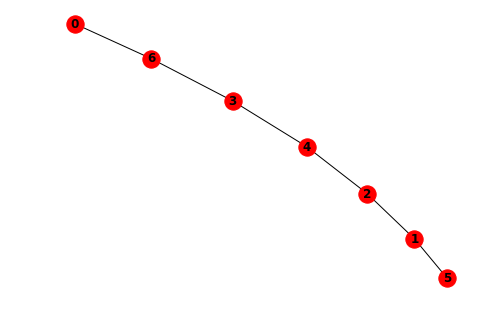

In [101]:
G = rand(7,0.1)#generate_regular(10,3)
nx.draw(G, with_labels=True, font_weight='bold')
print(alpha_centralities(G, 0.5))
# print(type(get_A(G)))
# print(G.adjacency())
# print(nx.linalg.graphmatrix.adjacency_matrix(G).todense())

6

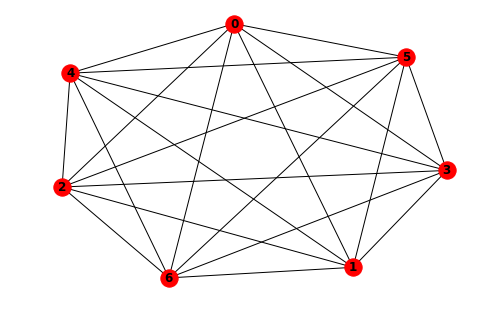

In [102]:
G = generate_simplex(7)
nx.draw(G, with_labels=True, font_weight='bold')
G.degree(0)

In [103]:
G.adj[0]

AtlasView({1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}})

In [126]:
graphs = [generate_simplex(i) for i in range(1,6)] + [generate_regular(10,3), generate_regular(10,2)]
centralities = {"degree": degree_centralities,
                "eigen": eigen_centralities,
#                 "alpha": alpha_centralities,
                "closeness": closeness_centralities,
                "betweenness": betweenness_centralities}    

def test(G):
#     plt.subplot(223)
#     nx.draw(G, with_labels=True, font_weight='bold')
    fig = plt.figure()
    ax = fig.add_subplot(2, 2, 2, projection='3d')
#     ax = plt.subplot(1, 2, 2, projection='3d')
    x = list(G.nodes)
    y = np.linspace(0.01, 0.99, 10)
    X, Y = np.meshgrid(x, y)
#     X, Y = x, y
    seqs = [alpha_centralities(G, alpha) for alpha in y]
#     print(seqs)
    Z = np.concatenate(seqs)
#     z = [[] for i in range(len(y))]
#     for i in range(len(y)):
#         z[i] = list(alpha_centralities(G, y[i]))
#     Z = np.array(z)
#     print(Z)
    print("X", X, "\n\nY", Y, "\n\nZ", Z)
    ax.plot_wireframe(X,Y,Z)

    
    data = {}
    for name, measure in centralities.items():
        data[name] = measure(G)
    plt.subplot(221)
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(data)))
    for i,name in enumerate(data):
#         print(name, data[name], list(G.nodes))
        plt.scatter(list(G.nodes), data[name], color=colors[i], label=name)
    plt.legend(loc="best")
#     nx.draw(G)
    plt.subplot(223)
    nx.draw(G, with_labels=True)



    
    

X [[0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]] 

Y [[0.01       0.01       0.01       0.01       0.01       0.01
  0.01      ]
 [0.11888889 0.11888889 0.11888889 0.11888889 0.11888889 0.11888889
  0.11888889]
 [0.22777778 0.22777778 0.22777778 0.22777778 0.22777778 0.22777778
  0.22777778]
 [0.33666667 0.33666667 0.33666667 0.33666667 0.33666667 0.33666667
  0.33666667]
 [0.44555556 0.44555556 0.44555556 0.44555556 0.44555556 0.44555556
  0.44555556]
 [0.55444444 0.55444444 0.55444444 0.55444444 0.55444444 0.55444444
  0.55444444]
 [0.66333333 0.66333333 0.66333333 0.66333333 0.66333333 0.66333333
  0.66333333]
 [0.77222222 0.77222222 0.77222222 0.77222222 0.77222222 0.77222222
  0.77222222]
 [0.88111111 0.88111111 0.88111111 0.88111111 0.88111111 0.88111111
  0.88111111]
 [0.99       0.99       0.99       0.99       0.99       0.99
  0.99      ]] 

Z [[ 0.14041

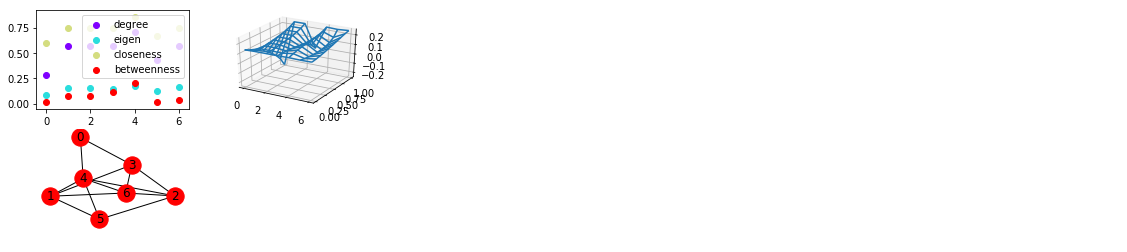

In [127]:
test(rand(7,0.5))#generate_regular(10,3))